In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor

In [2]:
#
# load the data
#
df = pd.read_csv('synth_temp.csv')

In [3]:
#
# slice 1902 and forward
#
df = df.loc[df.Year > 1901]

In [4]:
#
# roll up by year
#
df_group_year = df.groupby(['Year']).agg({'RgnAvTemp' : 'mean'})

In [5]:
#
# add the Year column so we can use that in a model
#
df_group_year['Year'] = df_group_year.index
df_group_year = df_group_year.rename(columns = {'RgnAvTemp' : 'AvTemp'})

In [6]:
#
# scale the data
#
X_min = df_group_year.Year.min()
X_range = df_group_year.Year.max() - df_group_year.Year.min()
Y_min = df_group_year.AvTemp.min()
Y_range = df_group_year.AvTemp.max() - df_group_year.AvTemp.min()
scale_X = (df_group_year.Year - X_min) / X_range
#
train_X = scale_X.ravel()
train_Y = ((df_group_year.AvTemp - Y_min) / Y_range).ravel()

In [7]:
#
# create the model object
#
np.random.seed(42)
model = SGDRegressor(
    loss = 'squared_loss',
    max_iter = 100,
    learning_rate = 'constant',
    eta0 = 0.0005,
    tol = 0.00009,
    penalty = 'none')

In [8]:
#
# fit the model
#
model.fit(train_X.reshape((-1, 1)), train_Y)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=100,
             n_iter_no_change=5, penalty='none', power_t=0.25,
             random_state=None, shuffle=True, tol=9e-05,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
Beta0 = (Y_min + Y_range * model.intercept_[0] - 
        Y_range * model.coef_[0] * X_min / X_range)
Beta1 = Y_range * model.coef_[0] / X_range
print(Beta0)
print(Beta1)

-0.5798539884018439
0.009587734834970016


In [10]:
#
# generate predictions
#
pred_X = df_group_year['Year']
pred_Y = model.predict(train_X.reshape((-1, 1)))

In [11]:
#
# calcualte the r squared value
#
r2 = r2_score(train_Y, pred_Y)
print('r squared = ', r2)

r squared =  0.5436475116024911


In [12]:
#
# scale predictions back to real values
#
pred_Y = (pred_Y * Y_range) + Y_min

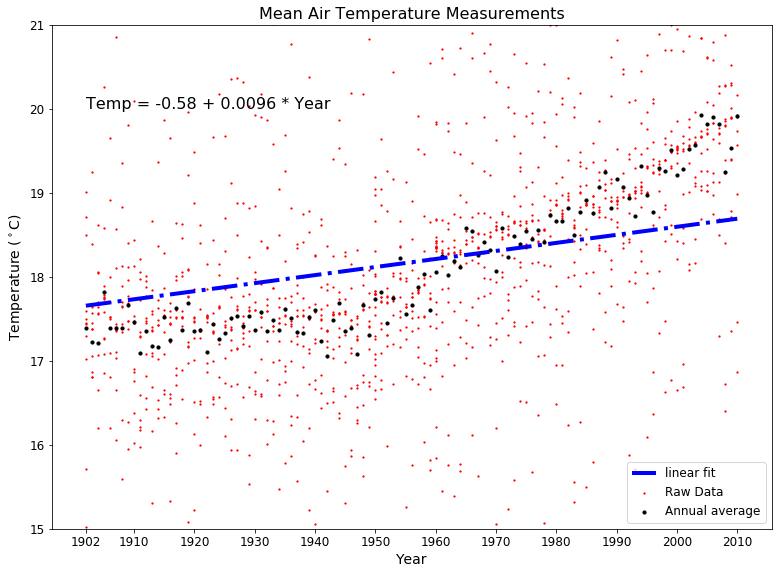

In [13]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([1, 1, 1, 1])
#
# Raw data
#
raw_plot_data = df
ax.scatter(raw_plot_data.Year, 
           raw_plot_data.RgnAvTemp, 
           label = 'Raw Data', 
           c = 'red',
           s = 1.5)
#
# Annual averages
#
ax.scatter(df_group_year.Year, 
           df_group_year.AvTemp, 
           label = 'Annual average', 
           c = 'k',
           s = 10)
#
# linear fit
#
ax.plot(pred_X, pred_Y, 
        c = "blue",
        linestyle = '-.',
        linewidth = 4,
        label = 'linear fit')
#
# put the model on the plot
#
ax.text(1902, 20,
        'Temp = ' + 
        str(round(Beta0, 2)) +
        ' + ' +
        str(round(Beta1, 4)) +
        ' * Year',
        fontsize = 16)
#
ax.set_title('Mean Air Temperature Measurements',
             fontsize = 16)
#
# make the ticks include the first and last years
#
tick_years = [1902] + list(range(1910, 2011, 10))
ax.set_xlabel('Year', 
              fontsize = 14)
ax.set_ylabel('Temperature ($^\circ$C)', 
              fontsize = 14)
ax.set_ylim(15, 21)
ax.set_xticks(tick_years)
ax.tick_params(labelsize = 12)
ax.legend(fontsize = 12)
plt.show()